# DS3 Predictive Modeling Kaggle Challenge
## Tanzanian Water Pump Functionality Predictions

## Kaggle Challenge Overview

![Tanzanian Water Pump Image](http://drivendata.materials.s3.amazonaws.com/pumps/pumping.jpg)

### Can you predict which water pumps are faulty?
Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

This predictive modeling challenge comes from DrivenData, an organization who helps non-profits by hosting data science competitions for social impact. The competition has open licensing: "The data is available for use outside of DrivenData." We are reusing the data on Kaggle's InClass platform so we can run a weeklong challenge just for your Lambda School Data Science cohort.

The data comes from the Taarifa waterpoints dashboard, which aggregates data from the Tanzania Ministry of Water. In their own words:

Taarifa is an open source platform for the crowd sourced reporting and triaging of infrastructure related issues. Think of it as a bug tracker for the real world which helps to engage citizens with their local government. We are currently working on an Innovation Project in Tanzania, with various partners.

![Taarifa Dashboard](http://drivendata.materials.s3.amazonaws.com/pumps/taarifadashboard.png)

In [2]:
# !kaggle competitions download -c ds3-predictive-modeling-challenge

In [3]:
# Loading potential tools needed not all are used
%matplotlib inline
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

# XGB Classification with Randomized Search CV Baseline
## No additional train test split

In [4]:
train_features = pd.read_csv('/home/seek/Documents/GitHub/DS-Project-2---Predictive-Modeling-Challenge/train_features.csv.zip')
pd.options.display.max_columns = 40
train_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
train_labels = pd.read_csv('/home/seek/Documents/GitHub/DS-Project-2---Predictive-Modeling-Challenge/train_labels.csv.zip')

train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [6]:
test_features = pd.read_csv('/home/seek/Documents/GitHub/DS-Project-2---Predictive-Modeling-Challenge/test_features.csv.zip')
pd.options.display.max_columns = 40
test_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [7]:
X_train = train_features
X_test = test_features
y_train = train_labels['status_group']

In [8]:
y_train.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [9]:
features = X_train.columns.tolist()
target = y_train

X = features
y = target

In [10]:
encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

param_distributions = {
    'n_estimators': randint(50, 300), 
    'max_depth': randint(2, 4)
}

# n_iter & cv parameters are low here so the example runs faster
search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=50, 
    scoring='accuracy', 
    n_jobs=-1, 
    cv=2, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed:  3.8min remaining:   31.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=42, reg_alpha=0,
                                           reg_lambda=1, sca...
                                           seed=None, silent=True,
                                           subsample=1),
                   iid='warn', n_iter=50, n_jobs=-1,
                   param_distributions={'max

In [11]:
estimator = search.best_estimator_

In [12]:
best = search.best_score_

In [13]:
estimator

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=113,
              n_jobs=-1, nthread=None, objective='multi:softprob',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [14]:
X_test = encoder.transform(X_test)
y_pred = estimator.predict(X_test)

In [15]:
y_pred

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [16]:
best

0.7465488215488215

In [17]:
submission = pd.read_csv('/home/seek/Documents/GitHub/DS-Project-2---Predictive-Modeling-Challenge/sample_submission.csv')
submission = submission.copy()
submission['status_group'] = y_pred
submission.to_csv('baseline.csv', index=False)

In [18]:
# !kaggle  competitions  submit -c ds3-predictive-modeling-challenge -f baseline.csv -m "Xgb baseline"

# Logistic Regression Evaluations

In [19]:
encoder = ce.OrdinalEncoder()
encoded_features = encoder.fit_transform(X_train)
print(f'1 column, {encoded_features.nunique()} unique values')
encoded_features.head()

1 column, id                       59400
amount_tsh                  98
date_recorded              356
funder                    1898
gps_height                2428
installer                 2146
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19288
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               3
recorded_by                  1
scheme_management           13
scheme_name               2697
permit                       3
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,1,1,1390,1,34.938093,-9.856322,1,0,1,1,1,11,5,1,1,109,1,1,1,1,1,1999,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,8776,0.0,2,2,1399,2,34.698766,-2.147466,2,0,2,2,2,20,2,2,2,280,2,1,2,2,2,2010,1,1,1,2,1,2,2,1,1,2,2,2,2,2,1,1
2,34310,25.0,3,3,686,3,37.460664,-3.821329,3,0,3,3,3,21,4,3,3,250,1,1,1,3,2,2009,1,1,1,1,1,3,3,1,1,1,1,3,3,2,2,1
3,67743,0.0,4,4,263,4,38.486161,-11.155298,4,0,4,4,4,90,63,4,4,58,1,1,1,2,2,1986,2,2,2,1,1,2,2,1,1,3,3,4,4,1,2,1
4,19728,0.0,5,5,0,5,31.130847,-1.825359,5,0,2,5,5,18,1,5,5,0,1,1,3,2,2,0,1,1,1,3,2,2,2,1,1,4,4,2,2,2,1,1


In [20]:
encoded_labels = encoder.fit_transform(y_train)
print(f'1 column, {encoded_labels.nunique()} unique values')
encoded_labels.head()

1 column, status_group    3
dtype: int64 unique values


,status_group
0,functional
1,functional
2,functional
3,non functional
4,functional


In [21]:
# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

In [22]:
from sklearn.model_selection import cross_val_predict
y_pred_proba = cross_val_predict(pipeline, X_train, y_train, cv=2, n_jobs=-1, 
                                 method='predict_proba')[:,1]

In [23]:
threshold = 0.08
y_pred = y_pred_proba >= threshold
correct = y_pred == y_train

labels = pd.DataFrame({'Ground Truth': y_train, 
                       'Predicted Probability': y_pred_proba, 
                       'Discrete Prediction': y_pred, 
                       'Correct Prediction?': correct})

labels.head()

,Ground Truth,Predicted Probability,Discrete Prediction,Correct Prediction?
0,functional,0.039417,False,False
1,functional,0.121480,True,False
2,functional,0.151421,True,False
3,non functional,0.055799,False,False
4,functional,0.151883,True,False


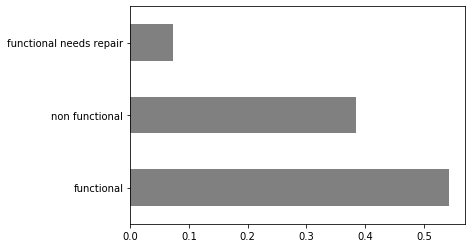

In [24]:
labels['Ground Truth'].value_counts(normalize=True).plot.barh(color='gray');

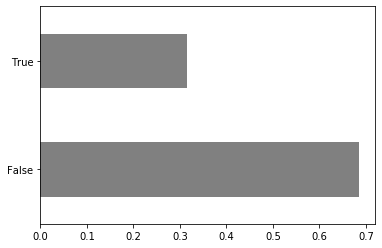

In [25]:
labels['Discrete Prediction'].value_counts(normalize=True).plot.barh(color='gray');

# XGB Classification with Randomized Search CV

## With additional train test split

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=42)

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

X_train_encoded = encoder.fit_transform(X_train[features])
X_val_encoded = encoder.transform(X_val[features])
# model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=50, 
    scoring='accuracy', 
    n_jobs=-1, 
    cv=2, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)
search.fit(X_train_encoded, y_train)
search.score(X_val_encoded, y_val)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed:  2.8min remaining:   23.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished


0.7678114478114478

In [28]:
estimator = search.best_estimator_

In [29]:
best = search.best_score_

In [30]:
best

0.7618406285072952

In [31]:
estimator

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=291,
              n_jobs=-1, nthread=None, objective='multi:softprob',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [32]:
X_test = encoder.transform(X_test)
y_pred = estimator.predict(X_test)

In [33]:
y_pred

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [34]:
submission2 = pd.read_csv('/home/seek/Documents/GitHub/DS-Project-2---Predictive-Modeling-Challenge/sample_submission.csv')
submission2 = submission2.copy()
submission2['status_group'] = y_pred
submission2.to_csv('baseline2.csv', index=False)

In [35]:
# !kaggle  competitions  submit -c ds3-predictive-modeling-challenge -f baseline2.csv -m "Xgb baseline 2"

# Predictive Model Confusion Matrix Results

In [36]:
y_pred = search.predict(X_val_encoded)
print(classification_report(y_val, y_pred))


columns = [f'Predicted {label}' for label in np.unique(y_val)]
index = [f'Actual {label}' for label in np.unique(y_val)]
pd.DataFrame(confusion_matrix(y_val, y_pred), columns=columns, index=index)

                         precision    recall  f1-score   support

             functional       0.74      0.92      0.82      8065
functional needs repair       0.64      0.14      0.24      1079
         non functional       0.83      0.67      0.74      5706

               accuracy                           0.77     14850
              macro avg       0.74      0.58      0.60     14850
           weighted avg       0.77      0.77      0.75     14850



,Predicted functional,Predicted functional needs repair,Predicted non functional
Actual functional,7401,51,613
Actual functional needs repair,744,156,179
Actual non functional,1823,38,3845


# XGB Classification with Grid Search CV 
## Cleaned dataset with engineered features and hyperparameter adjustments

In [37]:
X_train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [38]:
def CleanTrain(X_train):
    df_train = X_train
    df_train['gps_height'].replace(0.0, np.nan, inplace=True)
    df_train['population'].replace(0.0, np.nan, inplace=True)
    df_train['amount_tsh'].replace(0.0, np.nan, inplace=True)
    df_train['gps_height'].fillna(df_train.groupby(['region', 'district_code'])['gps_height'].transform('mean'), inplace=True)
    df_train['gps_height'].fillna(df_train.groupby(['region'])['gps_height'].transform('mean'), inplace=True)
    df_train['gps_height'].fillna(df_train['gps_height'].mean(), inplace=True)
    df_train['population'].fillna(df_train.groupby(['region', 'district_code'])['population'].transform('median'), inplace=True)
    df_train['population'].fillna(df_train.groupby(['region'])['population'].transform('median'), inplace=True)
    df_train['population'].fillna(df_train['population'].median(), inplace=True)
    df_train['amount_tsh'].fillna(df_train.groupby(['region', 'district_code'])['amount_tsh'].transform('median'), inplace=True)
    df_train['amount_tsh'].fillna(df_train.groupby(['region'])['amount_tsh'].transform('median'), inplace=True)
    df_train['amount_tsh'].fillna(df_train['amount_tsh'].median(), inplace=True)
    features=['amount_tsh', 'gps_height', 'population']
#     scaler = MinMaxScaler(feature_range=(0,20))
#     df_train[features] = scaler.fit_transform(df_train[features])
    df_train['longitude'].replace(0.0, np.nan, inplace=True)
    df_train['latitude'].replace(0.0, np.nan, inplace=True)
    df_train['construction_year'].replace(0.0, np.nan, inplace=True)
    df_train['latitude'].fillna(df_train.groupby(['region', 'district_code'])['latitude'].transform('mean'), inplace=True)
    df_train['longitude'].fillna(df_train.groupby(['region', 'district_code'])['longitude'].transform('mean'), inplace=True)
    df_train['longitude'].fillna(df_train.groupby(['region'])['longitude'].transform('mean'), inplace=True)
    df_train['construction_year'].fillna(df_train.groupby(['region', 'district_code'])['construction_year'].transform('median'), inplace=True)
    df_train['construction_year'].fillna(df_train.groupby(['region'])['construction_year'].transform('median'), inplace=True)
    df_train['construction_year'].fillna(df_train.groupby(['district_code'])['construction_year'].transform('median'), inplace=True)
    df_train['construction_year'].fillna(df_train['construction_year'].median(), inplace=True)
    df_train['date_recorded'] = pd.to_datetime(df_train['date_recorded'])
    df_train['years_service'] = df_train.date_recorded.dt.year - df_train.construction_year
    
    df_train.drop(columns=['date_recorded'])
   
   
    #further spacial/location information
    #https://www.kaggle.com/c/sf-crime/discussion/18853
    
    return df_train

In [39]:
clean_train = CleanTrain(X_train)

clean_train = clean_train.drop(columns=['date_recorded'])
clean_train.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,years_service
35240,28252,200.0,26,1757.000000,76,34.588740,-9.786994,1,0,1,2830,1,11,5,1,705,75.0,1,1,1,344,1,2001.0,1,1,1,1,1,7,7,1,1,1,1,1,1,1,1,1,-31.0
16282,49008,500.0,16,1664.000000,6,31.739103,-8.771693,11740,0,9,2373,12,15,2,15,861,300.0,1,1,1,2,1,1994.0,4,4,3,1,1,2,2,1,1,1,1,6,6,1,3,2,-24.0
57019,20957,250.0,12,1057.653373,22,33.922908,-9.499151,36125,0,1,17653,18,12,3,28,1014,200.0,1,1,1,526,2,2002.0,1,1,1,1,1,7,7,1,1,1,1,1,1,1,1,1,-32.0
30996,57627,500.0,166,1532.000000,159,34.820269,-11.108757,5,0,1,13611,10,10,3,98,447,260.0,2,1,5,134,2,2005.0,1,1,1,2,1,4,4,1,1,1,1,1,1,1,1,1,-35.0
21149,63291,50.0,24,-27.000000,308,38.900501,-6.451608,1137,0,7,1947,9,6,1,25,501,20.0,1,1,9,53,2,2009.0,7,2,2,4,3,3,3,1,1,1,1,7,7,2,1,1,-39.0


In [40]:
def CleanTest(X_test):
    df_test = X_test
    df_test['gps_height'].replace(0.0, np.nan, inplace=True)
    df_test['population'].replace(0.0, np.nan, inplace=True)
    df_test['amount_tsh'].replace(0.0, np.nan, inplace=True)
    df_test['gps_height'].fillna(df_test.groupby(['region', 'district_code'])['gps_height'].transform('mean'), inplace=True)
    df_test['gps_height'].fillna(df_test.groupby(['region'])['gps_height'].transform('mean'), inplace=True)
    df_test['gps_height'].fillna(df_test['gps_height'].mean(), inplace=True)
    df_test['population'].fillna(df_test.groupby(['region', 'district_code'])['population'].transform('median'), inplace=True)
    df_test['population'].fillna(df_test.groupby(['region'])['population'].transform('median'), inplace=True)
    df_test['population'].fillna(df_test['population'].median(), inplace=True)
    df_test['amount_tsh'].fillna(df_test.groupby(['region', 'district_code'])['amount_tsh'].transform('median'), inplace=True)
    df_test['amount_tsh'].fillna(df_test.groupby(['region'])['amount_tsh'].transform('median'), inplace=True)
    df_test['amount_tsh'].fillna(df_test['amount_tsh'].median(), inplace=True)
    features=['amount_tsh', 'gps_height', 'population']
#     scaler = MinMaxScaler(feature_range=(0,20))
#     df_test[features] = scaler.fit_transform(df_test[features])
    df_test['longitude'].replace(0.0, np.nan, inplace=True)
    df_test['latitude'].replace(0.0, np.nan, inplace=True)
    df_test['construction_year'].replace(0.0, np.nan, inplace=True)
    df_test['latitude'].fillna(df_test.groupby(['region', 'district_code'])['latitude'].transform('mean'), inplace=True)
    df_test['longitude'].fillna(df_test.groupby(['region', 'district_code'])['longitude'].transform('mean'), inplace=True)
    df_test['longitude'].fillna(df_test.groupby(['region'])['longitude'].transform('mean'), inplace=True)
    df_test['construction_year'].fillna(df_test.groupby(['region', 'district_code'])['construction_year'].transform('median'), inplace=True)
    df_test['construction_year'].fillna(df_test.groupby(['region'])['construction_year'].transform('median'), inplace=True)
    df_test['construction_year'].fillna(df_test.groupby(['district_code'])['construction_year'].transform('median'), inplace=True)
    df_test['construction_year'].fillna(df_test['construction_year'].median(), inplace=True)
    df_test['date_recorded'] = pd.to_datetime(df_test['date_recorded'])
    df_test['years_service'] = df_test.date_recorded.dt.year - df_test.construction_year
    
    df_test.drop(columns=['date_recorded'])
   
    
    return df_test

In [41]:
clean_test = CleanTest(X_test)
clean_test= clean_test.drop(columns=['date_recorded'])
clean_test.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,years_service
0,50785,20.0,164.0,1996.0,342.0,35.290799,-4.059696,-1.0,0,5,10944.0,3,21,3,38,574.0,321.0,1,1,10,2.0,2,2012.0,6,6,4,9,4,2,2,1,1,4,4,2,2,2,4,3,-42.0
1,51630,30.0,21.0,1569.0,6.0,36.656709,-3.309214,-1.0,0,3,-1.0,17,2,2,27,368.0,300.0,1,1,1,417.0,2,2000.0,1,1,1,1,1,2,2,1,1,2,2,1,1,1,1,1,-30.0
2,17168,50.0,26.0,1567.0,20.0,34.767863,-5.004344,21519.0,0,5,7345.0,19,13,2,33,648.0,500.0,1,1,1,938.0,3,2010.0,6,6,4,1,1,2,2,1,1,2,2,2,2,2,4,3,-40.0
3,45559,50.0,145.0,267.0,131.0,38.058046,-9.418672,-1.0,0,4,5580.0,15,80,43,106,1796.0,250.0,2,1,1,2.0,2,1987.0,6,6,4,1,1,4,4,1,1,3,3,6,6,1,4,3,-17.0
4,49871,500.0,1038.0,1260.0,1133.0,35.006123,-10.950412,2985.0,0,4,2891.0,10,10,3,98,654.0,60.0,2,1,6,319.0,2,2000.0,1,1,1,5,1,7,7,1,1,1,1,1,1,1,1,1,-30.0


In [42]:
X_train = clean_train
X_test = clean_test

In [43]:
features = X_train
target = y_train

In [44]:
X = features
y = target

In [45]:
X.shape, y.shape

((44550, 40), (44550,))

In [46]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, random_state=42, stratify=y_train)

In [49]:
from sklearn.model_selection import GridSearchCV
encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

param_grid = {'learning_rate': [0.075, 0.07],
                      'max_depth': [6, 7],
                      'min_samples_leaf': [7,8],
                      'max_features': [1.0],
                      'n_estimators':[100, 200]} 

search = GridSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), 
    param_grid=param_grid, 
    scoring='accuracy', 
    n_jobs=-1, 
    cv=10, 
    verbose=10, 
    return_train_score=True,
)

search.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 154 out of 160 | elapsed: 16.0min remaining:   37.4s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 16.1min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bytree=1,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=-1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=True,
                                     subsample=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.075, 0.07], 'max_depth': [6, 7],
                         'max_features': [1.0], 'min_samples_leaf': [7, 8],
                         'n_estimators': [100

In [50]:
search.score(X_train, y_train)

0.8595414821022387

In [51]:
# search.fit(X_train_encoded, y_train)

In [52]:
estimator = search.best_estimator_

In [53]:
estimator

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.07, max_delta_step=0,
              max_depth=7, max_features=1.0, min_child_weight=1,
              min_samples_leaf=7, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1)

In [64]:
best = search.best_score_
best

0.7925894888064169

In [65]:
X_train = encoder.fit_transform(X_train)

In [66]:
params = search.best_params_

In [67]:
X_test = encoder.transform(X_test)
y_pred = search.predict(X_test)

In [68]:
y_pred

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [69]:
submission3 = pd.read_csv('/home/seek/Documents/GitHub/DS-Project-2---Predictive-Modeling-Challenge/sample_submission.csv')
submission3 = submission3.copy()
submission3['status_group'] = y_pred
submission3.to_csv('clean_grid.csv', index=False)

In [70]:
# !kaggle  competitions  submit -c ds3-predictive-modeling-challenge -f clean_grid.csv -m "Xgb clean Gridsearch"

100%|█████████████████████████████████████████| 260k/260k [00:00<00:00, 318kB/s]
Successfully submitted to DS3 Predictive Modeling Challenge

# Yay! Another Confusion Matrix on the model

In [73]:
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.fit_transform(X_test)
X_val_encoded = encoder.fit_transform(X_val)

In [76]:
y_pred = search.predict(X_val_encoded)
print(classification_report(y_val, y_pred))


columns = [f'Predicted {label}' for label in np.unique(y_val)]
index = [f'Actual {label}' for label in np.unique(y_val)]
pd.DataFrame(confusion_matrix(y_val, y_pred), columns=columns, index=index)

                         precision    recall  f1-score   support

             functional       0.77      0.91      0.84      6049
functional needs repair       0.64      0.23      0.34       809
         non functional       0.84      0.73      0.78      4280

               accuracy                           0.79     11138
              macro avg       0.75      0.62      0.65     11138
           weighted avg       0.79      0.79      0.78     11138



,Predicted functional,Predicted functional needs repair,Predicted non functional
Actual functional,5526,62,461
Actual functional needs repair,483,185,141
Actual non functional,1131,44,3105


# Model Feature Importances

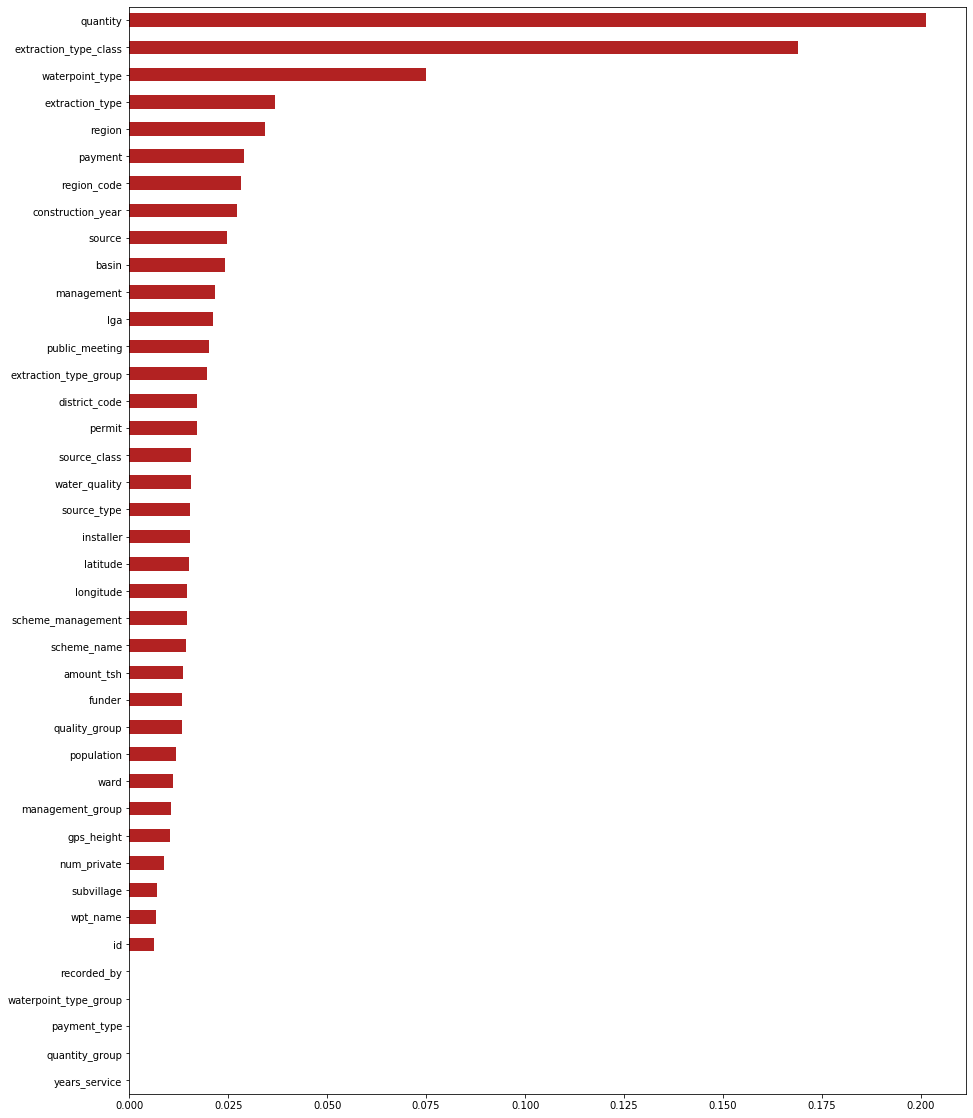

In [91]:
n = len(X_train.columns)
figsize = (15,20)

importances = pd.Series(search.best_estimator_.feature_importances_, X_train.columns)

top_n = importances.sort_values()[-n:]
plt.figure(figsize=figsize)
top_n.plot.barh(color='firebrick');

# Model Permutation Importances with ELI5

In [121]:
permuter = PermutationImportance(search, scoring='accuracy', cv='prefit',
                     n_iter=2, random_state=42)

permuter.fit(X_val, y_val)

PermutationImportance(cv='prefit',
                      estimator=GridSearchCV(cv=10,
                                             error_score='raise-deprecating',
                                             estimator=XGBClassifier(base_score=0.5,
                                                                     booster='gbtree',
                                                                     colsample_bylevel=1,
                                                                     colsample_bytree=1,
                                                                     gamma=0,
                                                                     learning_rate=0.1,
                                                                     max_delta_step=0,
                                                                     max_depth=3,
                                                                     min_child_weight=1,
                                                            

In [122]:
feature_names = X_test.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.1065 ± 0.0009,quantity
0.0268 ± 0.0013,waterpoint_type
0.0212 ± 0.0048,payment
0.0208 ± 0.0005,construction_year
0.0169 ± 0.0017,latitude
0.0158 ± 0.0036,extraction_type
0.0149 ± 0.0002,longitude
0.0125 ± 0.0022,population
0.0110 ± 0.0034,source
0.0089 ± 0.0025,installer


# Fun with Visualizing Model with Simple Partial Dependence Plots

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


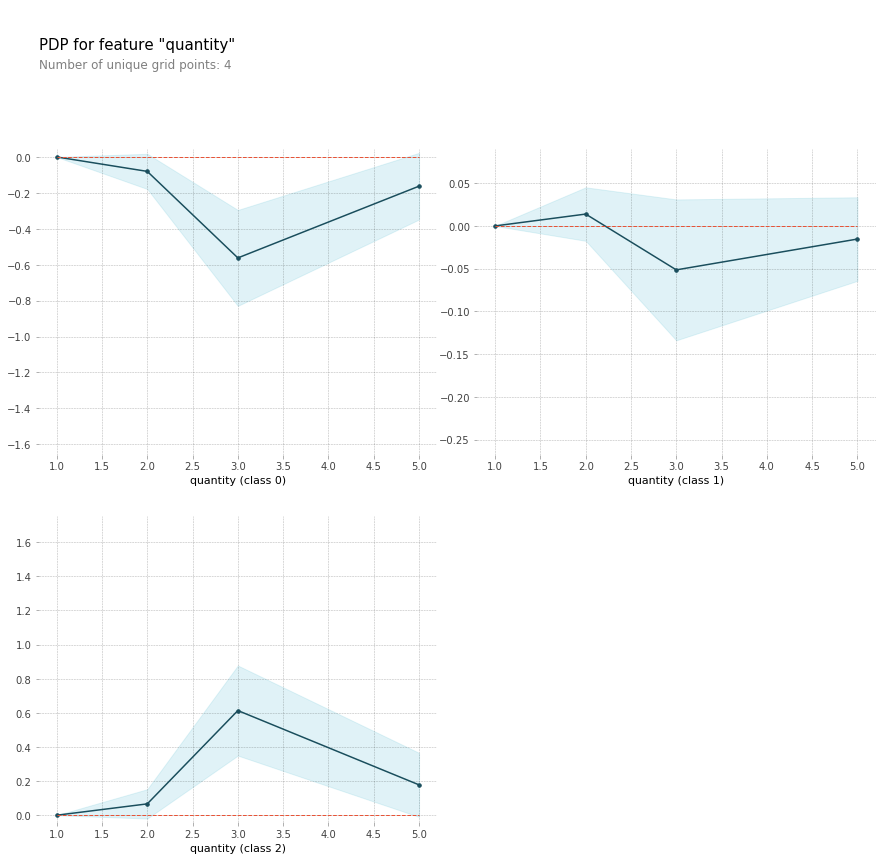

In [124]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature= 'quantity'
isolated = pdp_isolate(model=search, dataset=X_test, model_features=X_test.columns, feature=feature)

pdp_plot(isolated, feature_name=feature);

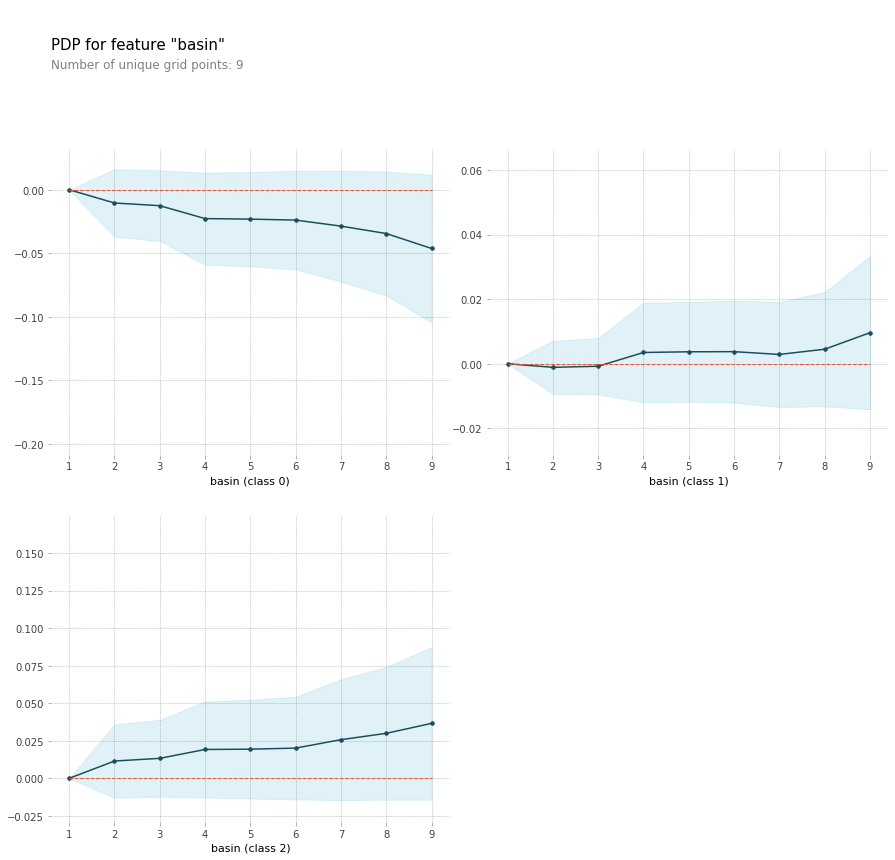

In [145]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature= 'basin'
isolated = pdp_isolate(model=search, dataset=X_test, model_features=X_test.columns, feature=feature)

pdp_plot(isolated, feature_name=feature);

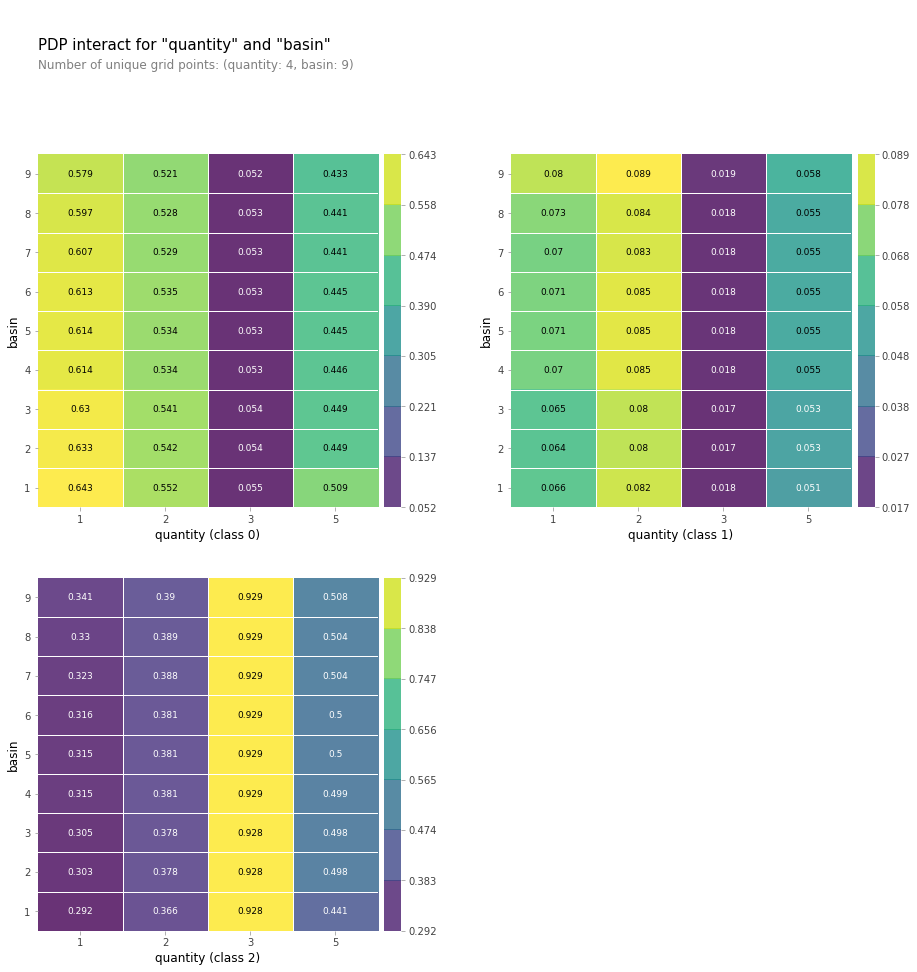

In [146]:
features = ['quantity', 'basin']

interaction = pdp_interact(
    model=search, 
    dataset=X_test, 
    model_features=X_test.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

# The End